## Business challenge.
Financial institutions struggle with evaluating loan applicants efficiently, leading to approval delays, high default rates and potential biases. Traditional models rely on rigid criteria, overlooking valuable insights from alternative data.

Loan Approval Predictor aims to build a predictive model that leverages historical loan data, borrower profiles  and classification techniques to refine loan approval decisions. By enhancing risk assessment and promoting fair, accessible credit opportunities, it seeks to improve financial inclusion and operational efficiency.


## Objectives
1. Enhance loan approval accuracy by leveraging historical data and predictive modeling techniques.

2. Minimize default risk by identifying high-risk applicants through classification algorithms.

3. Promote fairness in lending by analyzing biases in loan approval decisions and improving accessibility.

4. Streamline decision-making by automating loan approval predictions to reduce processing time.

5. Improve model interpretability to ensure stakeholders understand key factors influencing loan approvals.


In [68]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score





### 1.Loading and Inspecting  data

In [85]:
#Load the dataset in Python using pandas and inspect the first few rows

df=pd.read_csv("loan_data.csv")
df.head(10)


,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
5,21.0,female,High School,12951.0,0,OWN,2500.0,VENTURE,7.14,0.19,2.0,532,No,1
6,26.0,female,Bachelor,93471.0,1,RENT,35000.0,EDUCATION,12.42,0.37,3.0,701,No,1
7,24.0,female,High School,95550.0,5,RENT,35000.0,MEDICAL,11.11,0.37,4.0,585,No,1
8,24.0,female,Associate,100684.0,3,RENT,35000.0,PERSONAL,8.90,0.35,2.0,544,No,1
9,21.0,female,High School,12739.0,0,OWN,1600.0,VENTURE,14.74,0.13,3.0,640,No,1


This dataset contains loan application records, including applicant demographics, financial details, credit history and loan approval status. It aims to identify patterns in borrower profiles and factors influencing loan approvals.

In [84]:
# Checking the shape of the dataset (rows, columns)

df.shape

(45000, 14)

In [86]:
# Checking dataset structure and column details

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

 The above displays the number of non-null values, data types and memory usage, 
helping us identify missing data and potential type conversions.


In [87]:
# Convert categorical variables to category type
categorical_cols = ['person_gender', 'person_education', 'person_home_ownership', 
                   'loan_intent', 'previous_loan_defaults_on_file', 'loan_status']
for col in categorical_cols:
    df[col] = df[col].astype('category')
categorical_cols



['person_gender',
 'person_education',
 'person_home_ownership',
 'loan_intent',
 'previous_loan_defaults_on_file',
 'loan_status']

In [88]:
# Handle outliers using IQR
numeric_cols = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 
                'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 
                'credit_score']
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
numeric_cols

['person_age',
 'person_income',
 'person_emp_exp',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'credit_score']

In [89]:
print("\nProcessed Data Info:")
print(df.describe(include='all'))


Processed Data Info:
          person_age person_gender person_education  person_income  \
count   45000.000000         45000            45000   45000.000000   
unique           NaN             2                5            NaN   
top              NaN          male         Bachelor            NaN   
freq             NaN         24841            13399            NaN   
mean       27.444733           NaN              NaN   75677.400428   
std         4.930055           NaN              NaN   38071.779506   
min        20.000000           NaN              NaN    8000.000000   
25%        24.000000           NaN              NaN   47204.000000   
50%        26.000000           NaN              NaN   67048.000000   
75%        30.000000           NaN              NaN   95789.250000   
max        39.000000           NaN              NaN  168667.125000   

        person_emp_exp person_home_ownership     loan_amnt loan_intent  \
count     45000.000000                 45000  45000.000000     

In [90]:
df.to_csv("cleaned_loan_data.csv", index=False)
print("Cleaned data saved to 'cleaned_loan_data.csv'")

Cleaned data saved to 'cleaned_loan_data.csv'


### 2. Exploratory Data Analysis(EDA)

In [91]:
# Load the cleaned dataset
df = pd.read_csv("cleaned_loan_data.csv")
df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0.0,RENT,23093.125,PERSONAL,16.02,0.37,3.0,561.0,No,1
1,21.0,female,High School,12282.0,0.0,OWN,1000.000,EDUCATION,11.14,0.08,2.0,504.0,Yes,0
2,25.0,female,High School,12438.0,3.0,MORTGAGE,5500.000,MEDICAL,12.87,0.37,3.0,635.0,No,1
3,23.0,female,Bachelor,79753.0,0.0,RENT,23093.125,MEDICAL,15.23,0.37,2.0,675.0,No,1
4,24.0,male,Master,66135.0,1.0,RENT,23093.125,MEDICAL,14.27,0.37,4.0,586.0,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6.0,RENT,15000.000,MEDICAL,15.66,0.31,3.0,645.0,No,1
44996,37.0,female,Associate,65800.0,17.0,RENT,9000.000,HOMEIMPROVEMENT,14.07,0.14,11.0,621.0,No,1
44997,33.0,male,Associate,56942.0,7.0,RENT,2771.000,DEBTCONSOLIDATION,10.02,0.05,10.0,668.0,No,1
44998,29.0,male,Bachelor,33164.0,4.0,RENT,12000.000,EDUCATION,13.23,0.36,6.0,604.0,No,1


In [92]:
# Summary statistics
print("EDA Summary Statistics:")
print(df.describe(include='all'))

EDA Summary Statistics:
          person_age person_gender person_education  person_income  \
count   45000.000000         45000            45000   45000.000000   
unique           NaN             2                5            NaN   
top              NaN          male         Bachelor            NaN   
freq             NaN         24841            13399            NaN   
mean       27.444733           NaN              NaN   75677.400428   
std         4.930055           NaN              NaN   38071.779506   
min        20.000000           NaN              NaN    8000.000000   
25%        24.000000           NaN              NaN   47204.000000   
50%        26.000000           NaN              NaN   67048.000000   
75%        30.000000           NaN              NaN   95789.250000   
max        39.000000           NaN              NaN  168667.125000   

        person_emp_exp person_home_ownership     loan_amnt loan_intent  \
count     45000.000000                 45000  45000.000000   

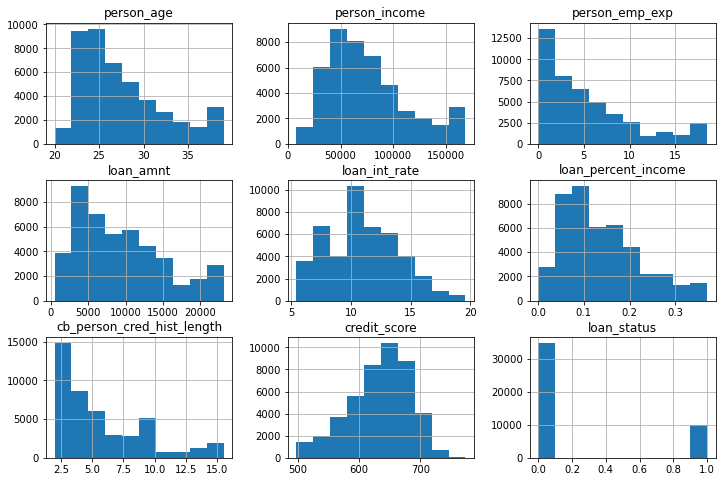

In [69]:
# Plot histograms for numerical features

df.hist(figsize=(12, 8))
plt.show()


The image presents nine bar charts visualizing key attributes of loan applicants, including age distribution,annual income, work experience, loan amounts, interest rates, debt-to-income ratio,credit history length, credit scores and loan approval rates. The visualizations highlight trends, such as most applicants being between 20-50 years old, earning under $2 million annually, and maintaining credit scores in the 600-800 range. Additionally, the majority of loans are under $10,000, with approval rates favoring financially stable borrowers. These insights help assess borrowing patterns and potential risk factors in loan approvals.


Text(0.5, 0, 'Loan Status (0 = No, 1 = Yes)')

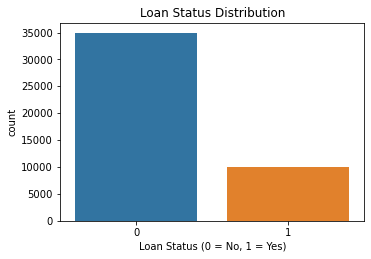

In [59]:
# Loan Status Distribution
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.countplot(x='loan_status', data=df)
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status (0 = No, 1 = Yes)')

This indicates that a substantial majority of loan applications in the dataset were rejected, highlighting a potential class imbalance that could impact predictive modeling efforts for loan approval decisions.

Text(0, 0.5, 'Loan Amount')

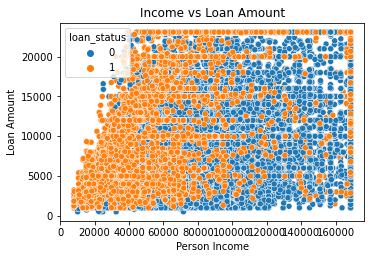

In [93]:
# Income vs Loan Amount
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 2)
sns.scatterplot(x='person_income', y='loan_amnt', hue='loan_status', data=df)
plt.title('Income vs Loan Amount')
plt.xlabel('Person Income')
plt.ylabel('Loan Amount')


The scatter plot illustrates that defaults (orange) are more frequent at lower incomes (below 100,000) and various loan amounts, while approved loans (blue) dominate at higher incomes (above 100,000), especially for larger loan amounts up to 15,000.

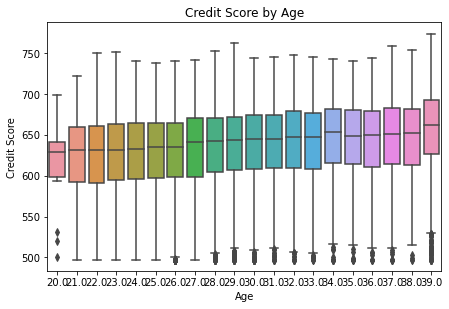

In [65]:
# Credit Score by Age (Box Plot)
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.boxplot(x='person_age', y='credit_score', data=df)
plt.title('Credit Score by Age')
plt.xlabel('Age')
plt.ylabel('Credit Score')
plt.tight_layout()
plt.show()


Credit scores tend to improve and stabilize with age, with younger people showing more variation and lower scores, while older groups have higher, more consistent scores.

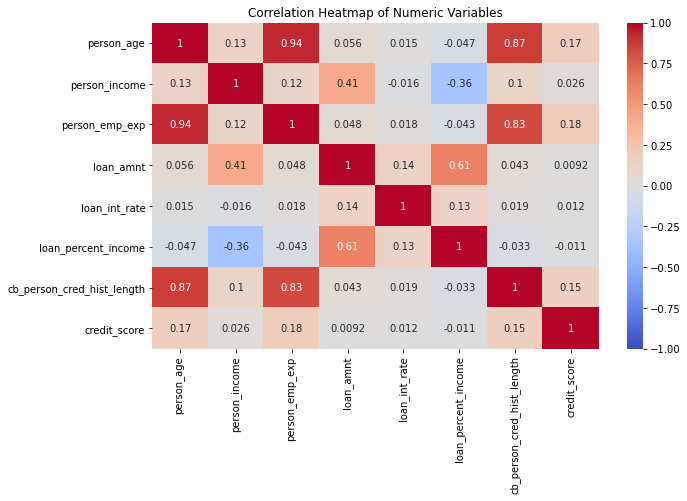

In [66]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

+ person_age and cb_person_cred_hist_length: 0.87 (strong positive correlation), meaning older people tend to have longer credit histories.
+ person_age and person_emp_exp: 0.94 (very strong positive correlation), indicating older individuals generally have more employment experience.
+ person_income and loan_amnt: 0.41 (moderate positive correlation), suggesting higher income is associated with larger loan amounts.
+ loan_amnt and loan_percent_income: 0.61 (moderate positive correlation), meaning larger loans are a bigger percentage of income.
+ person_income and loan_percent_income: -0.36 (moderate negative correlation), indicating higher income is linked to a smaller loan-to-income ratio.
+ person_age and loan_percent_income: -0.47 (moderate negative correlation), suggesting older people have a smaller loan-to-income ratio.
+ Most other pairs (e.g., credit_score with most variables) show weak correlations (close to 0), indicating little relationship.

Summary: Age strongly correlates with employment experience and credit history length. Loan amount and loan-to-income ratio are moderately related, and higher income tends to lower the loan-to-income ratio. Credit score has weak correlations with most variables.

In [67]:
# Insight
correlation = df['person_income'].corr(df['loan_amnt'])
print(f"\nInsight: There is a correlation of {correlation:.2f} between person_income and loan_amnt, suggesting higher incomes are associated with larger loans.")


Insight: There is a correlation of 0.41 between person_income and loan_amnt, suggesting higher incomes are associated with larger loans.
